In [56]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm


###在相同的数据学习预测函数的参数是一个方法论错误：一个只会重复刚刚看到的样本标签的模型会有完美的分数，但无法在尚未看到的数据上
#预测任何有用的东西。这种情况称为过拟合。 为了避免这种情况，这是执行时的常见做法 （监督）机器学习实验 将部分可用数据保留为测试集。 
#下面是模型训练中典型交叉验证工作流的流程图。 最佳参数可以通过网格搜索技术确定

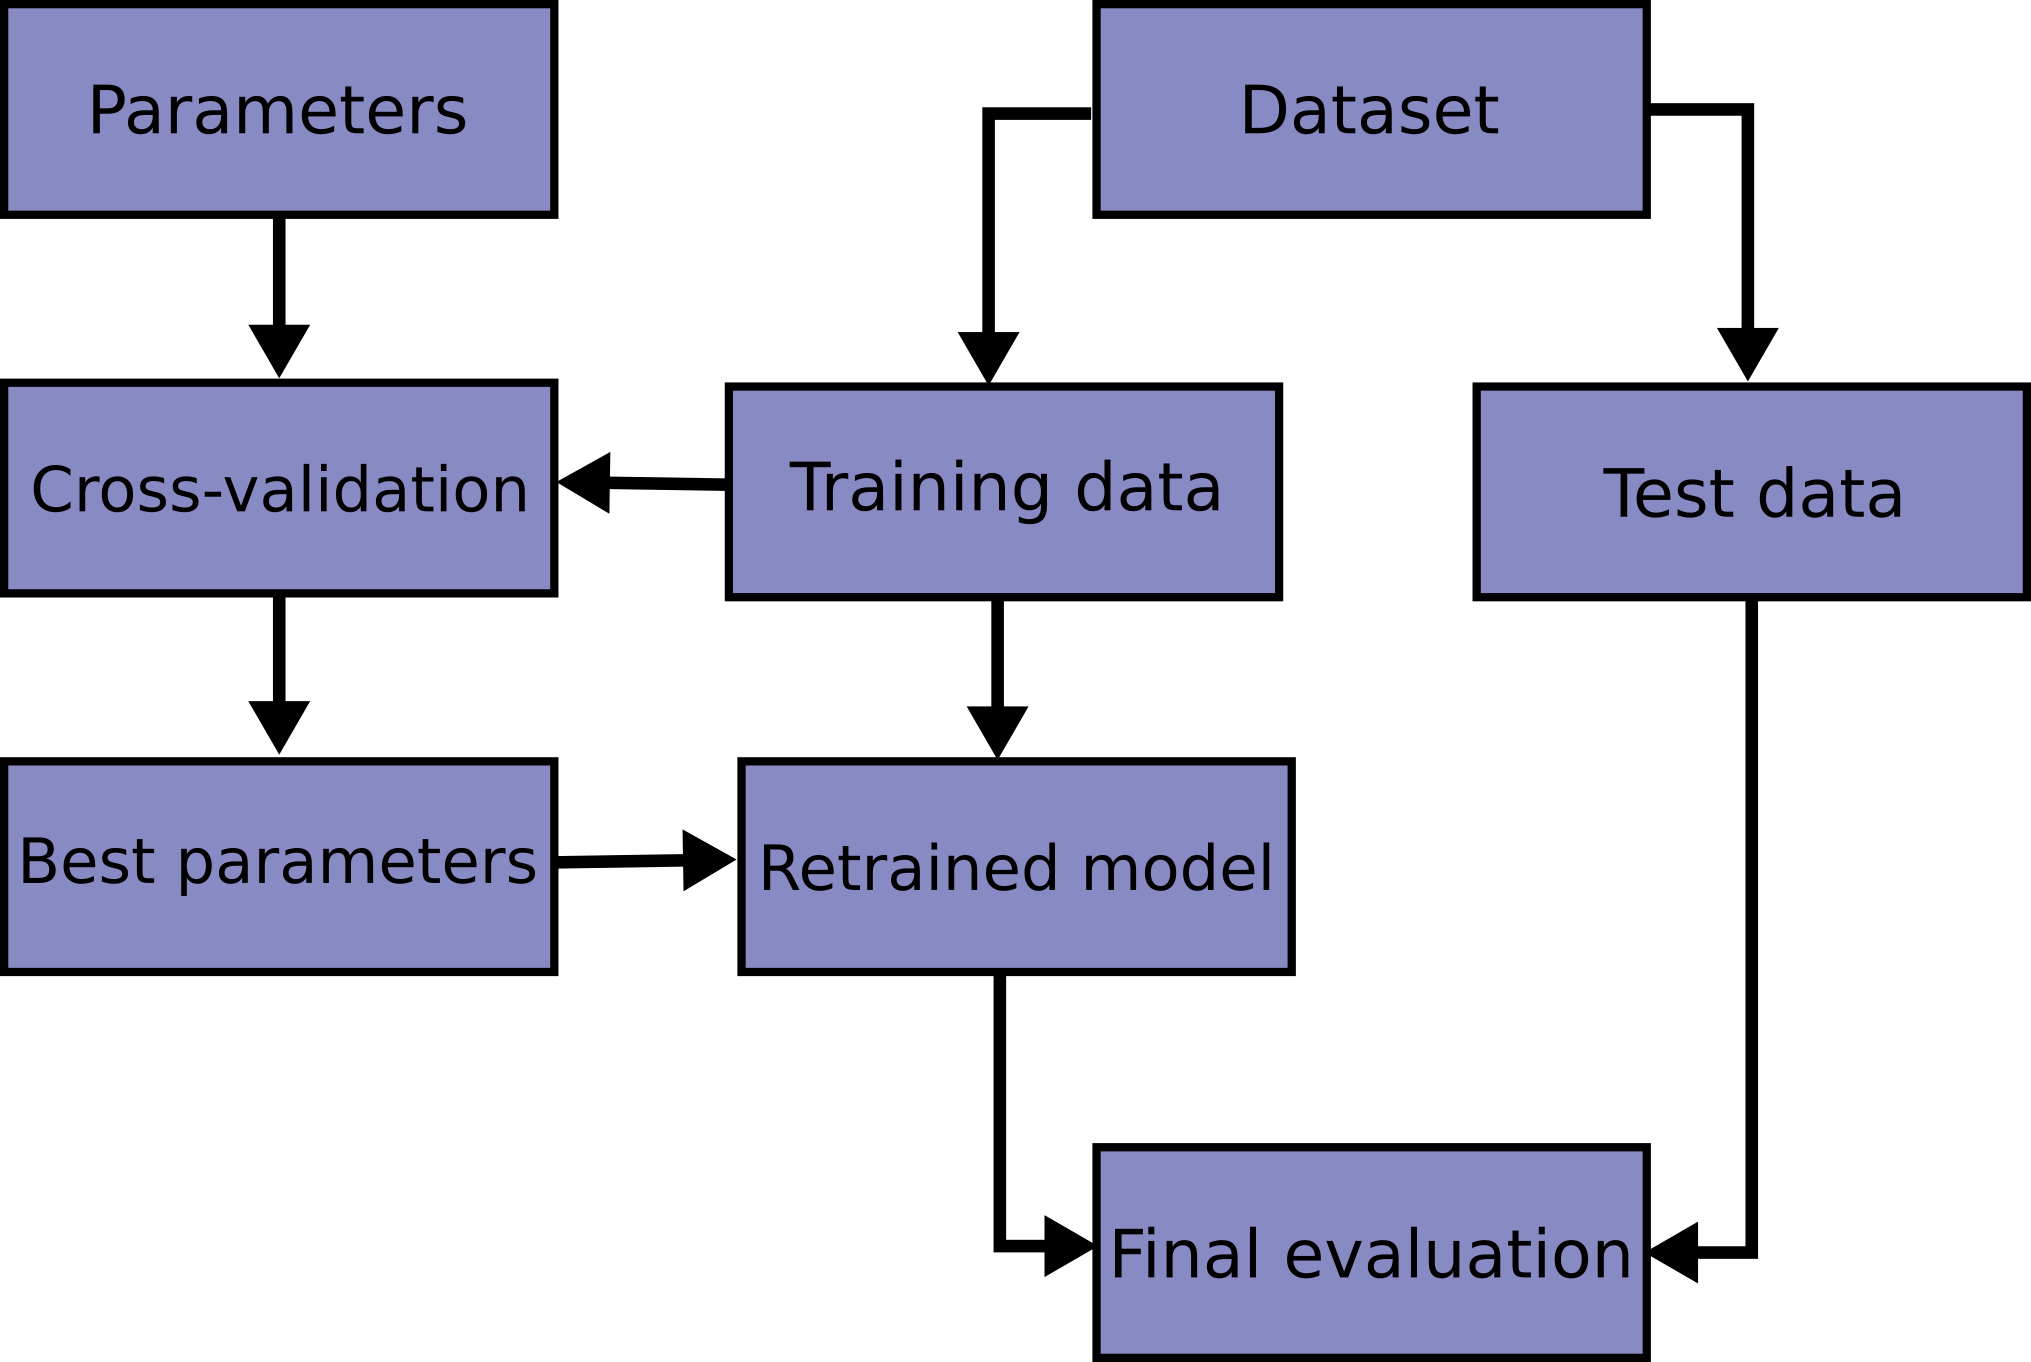

In [57]:
###3.1.1 随机化划分样本
#在scikit-learn中，随机分为训练集和测试集 可以使用辅助函数快速计算。 让我们加载虹膜数据集以拟合其上的线性支持向量机：

## 加载iris数据
X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

In [58]:
## 划分样本
#现在，我们可以快速对训练集进行采样，同时保留 40% 的 用于测试（评估）我们的分类器的数据：
X_train, X_test, y_train, y_test = train_test_split(   # 分别对X和y进行随机抽样，返回的4个dataframe分别是X的训练集、X的测试集，
                                                       # y的训练集和y的测试集。
    X, y, test_size=0.4, random_state=0)       # test_size表示测试集比例 ，random_state表示抽样时的随机种子。     

X_train.shape, y_train.shape
X_test.shape, y_test.shape

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9666666666666667

In [59]:
### 3.1.2 交叉验证的指标

##
#使用交叉验证的最简单方法是在估计器和数据集上调用帮助程序函数。
#下面的示例演示如何通过拆分数据、拟合在IRIS数据集上的核支持向量机估计accuracy ， 一个模型并连续计算分数 5 次（每次都有不同的拆分）：
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=5)        #5折交叉，每次取1/5的样本作为测试集，其他作为训练集样本训练模型，一共有5个模型。
scores


array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

In [60]:
#因此，平均分数和标准差由下式给出：
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.02


In [61]:
#默认情况下，每次 CV 迭代时计算的分数是估算器的方法。可以使用scoring 评分参数进行设置：
from sklearn import metrics
scores = cross_val_score(
    clf, X, y, cv=5, scoring='f1_macro')  #宏平均f1指标
scores                                    #在 Iris 数据集的情况下，样本在目标之间是平衡的 因此，准确率和 F1 分数几乎相等。

array([0.96658312, 1.        , 0.96658312, 0.96658312, 1.        ])

In [62]:
from sklearn import metrics
scores = cross_val_score(
    clf, X, y, cv=5, scoring='f1_micro') #微平均f1指标
scores                                   

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

In [63]:
## cross_validate函数和多指标计算
# 多个指标可以指定为列表、元组或一组 预定义的评分器名称：
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['precision_macro', 'recall_macro']            #同时评估多个指标
clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores = cross_validate(clf, X, y, scoring=scoring)
sorted(scores.keys())
scores   #scores['test_recall_macro']    #fit_time 是指每个交叉验证折叠中模型拟合（训练）所花费的时间。
                                         #score_time 是指每个交叉验证折叠中模型评估（预测）所花费的时间。

{'fit_time': array([0.00099683, 0.00199556, 0.00099802, 0.00199413, 0.00099778]),
 'score_time': array([0.00599408, 0.00398803, 0.00398779, 0.0029912 , 0.00371647]),
 'test_precision_macro': array([0.96969697, 1.        , 0.96969697, 0.96969697, 1.        ]),
 'test_recall_macro': array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])}

In [64]:
#或者作为字典将评分器名称映射到预定义或自定义评分函数：
from sklearn.metrics import make_scorer
scoring = {'prec_macro': 'precision_macro',
           'rec_macro': make_scorer(recall_score, average='macro')}
scores = cross_validate(clf, X, y, scoring=scoring,    # 字典结构的scoring参数可以自定义指标名称
                        cv=5, return_train_score=True) # return_train_score是否返回训练分数
sorted(scores.keys())
scores #['train_rec_macro']


{'fit_time': array([0.00199723, 0.00199699, 0.00199509, 0.00299191, 0.00599289]),
 'score_time': array([0.00598383, 0.00797653, 0.00797987, 0.01396346, 0.00896668]),
 'test_prec_macro': array([0.96969697, 1.        , 0.96969697, 0.96969697, 1.        ]),
 'train_prec_macro': array([0.97674419, 0.97674419, 0.99186992, 0.98412698, 0.98333333]),
 'test_rec_macro': array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ]),
 'train_rec_macro': array([0.975     , 0.975     , 0.99166667, 0.98333333, 0.98333333])}

In [65]:
### 3.1.3 交叉验证迭代器
## 3.1.3.1 - i.i.d.数据的交叉验证迭代器
#假设一些数据是独立和同一分布的（i.i.d.），则假设所有样本都来自同一生成过程，并且假设生成过程对过去生成的样本没有记忆。

#(1) K-fold K折交叉验证
#KFold 将所有样品分成样本K组，模型训练使用k-1折数据，剩下的1折用于模型预测。

#对具有 4 个样本的数据集进行 2 倍交叉验证的示例
import numpy as np
from sklearn.model_selection import KFold

X = ["a", "b", "c", "d"]
kf = KFold(n_splits=2)
for train, test in kf.split(X):    #返回X的索引，可以通过索引取数据。
    print("%s %s" % (train, test)) #[2 3] [0 1]表示索引为2/3的样本作为训练集，索引为0/1的样本作为测试集。



[2 3] [0 1]
[0 1] [2 3]


In [66]:
#(2)重复 K 折
#RepeatedKFold重复K-Fold n次。当需要运行KFold n次时，可以使用它，在每次重复中产生不同的拆分。
#重复2次的2倍K-fold的例子：
import numpy as np
from sklearn.model_selection import RepeatedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
random_state = 12883823
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
for train, test in rkf.split(X): #重复2次2折，每次结果不一样
    print("%s %s" % (train, test))

[2 3] [0 1]
[0 1] [2 3]
[0 2] [1 3]
[1 3] [0 2]


In [67]:
#（3）<进阶> 遗漏一个 （LOO）
#LeaveOneOut (or LOO) 是一种简单的交叉验证。每个训练集都是通过提取除一个样本外的所有样本创建的，测试集是遗漏的样本。
#因此，对于样本，我们有不同的训练集和测试集。这种交叉验证程序不会浪费太多数据。
from sklearn.model_selection import LeaveOneOut

X = [1, 2, 3, 4]
loo = LeaveOneOut()
for train, test in loo.split(X):   #一个样本作为测试集，其余样本作为训练集。
    print("%s %s" % (train, test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


In [68]:
#（4）<进阶> 将 P 排除在外 （LPO）
#LeavePOut与LeaveOneOut非常相似，因为它通过从全集中删除p个样本来创建所有可能的训练/测试集。
#对于n个样本，这将生成n选p个训练测试对。与LeaveOneOut和KFold不同，测试集将重叠（p>1）。

#在具有4个样本的数据集上的Leave-2-Out示例：
from sklearn.model_selection import LeavePOut

X = np.ones(4)
lpo = LeavePOut(p=2)
for train, test in lpo.split(X):   
    print("%s %s" % (train, test))

[2 3] [0 1]
[1 3] [0 2]
[1 2] [0 3]
[0 3] [1 2]
[0 2] [1 3]
[0 1] [2 3]


In [69]:
#（5）<进阶> ShuffleSplit
#ShuffleSplit 是一种交叉验证的方法，它将数据集随机打乱并划分为训练集和测试集，然后重复进行多次（通过参数 n_splits 指定），每次划分都是随机的。
from sklearn.model_selection import ShuffleSplit
X = np.arange(10)
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0) #注意与train_test_split（通常情况下，它只执行一次划分，不会重复多次）的区别。
for train_index, test_index in ss.split(X):
    print("%s %s" % (train_index, test_index))

[9 1 6 7 3 0 5] [2 8 4]
[2 9 8 0 6 7 4] [3 5 1]
[4 5 1 0 6 9 7] [2 3 8]
[2 7 5 8 0 3 4] [6 1 9]
[4 1 0 6 8 9 3] [5 2 7]


In [70]:
##<进阶> 3.1.3.2 基于类标签分层的交叉验证迭代器 
#一些分类问题的样本类别在分布中可能表现出很大的不平衡，例如负样本数量可能要高出数倍于阳性样本。
#在这种情况下，建议使用StratifiedKFold和StratifiedShuffleSplit中实施的分层采样，以确保在每个训练和验证flod中大致保留相等的类别数量。

#（1）Stratified k-fold - 分层K折
#StratifiedKFold是 k-fold的变体，它返回分层折叠：每个集合包含的每个目标类的样本百分比与全集大致相同。
#这里是一个在数据集上进行分层3倍交叉验证的例子，该数据集有来自两个不平衡类的50个样本。我们显示了每个类别中的样本数量，并与KFold进行了比较。

from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))  # 0 类有45个样本，1类有5个样本
skf = StratifiedKFold(n_splits=3)
print('>>>>>>>>>>StratifiedKFold>>>>>>>>>>>>>>>>')
for train, test in skf.split(X, y):
    print(y[train],y[test])
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])),'\n') #np.bincount 是 NumPy 中一个用于统计非负整数数组中每个元素出现次数的函数。
                                                         #它返回一个数组，其中第 i 个元素表示整数 i 在输入数组中出现的次数。
                                                         #因此，test -  [15  2] 表示测试集中标签为0的样本有15个，标签为1的样本有2个。
kf = KFold(n_splits=3)
print('>>>>>>>>>>>KFold>>>>>>>>>>>>>>>')
for train, test in kf.split(X, y):
    print(y[train],y[test])
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])),'\n')  #对比可知StratifiedKFold抽样结果类别分布更均匀。


>>>>>>>>>>StratifiedKFold>>>>>>>>>>>>>>>>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
train -  [30  3]   |   test -  [15  2] 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
train -  [30  3]   |   test -  [15  2] 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
train -  [30  4]   |   test -  [15  1] 

>>>>>>>>>>>KFold>>>>>>>>>>>>>>>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
train -  [28  5]   |   test -  [17] 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
train -  [28  5]   |   test -  [17] 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
train -  [34]   |   test -  [11  5] 



In [71]:
##<进阶> 3.1.3.3. 分组数据的交叉验证迭代器
#类似KFold，分层抽样提供了更多针对分GroupKFold、StratifiedGroupKFold、LeaveOneGroupOut、LeavePGroupsOut、GroupShuffleSplit
#更多请参考 https://scikit-learn.org/stable/modules/cross_validation.html